In [144]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

In [145]:
# Load dataset
data = pd.read_csv("/Users/cheryl/Downloads/credit_card_churn.csv")

print(data)

       CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      768805383  Existing Customer            45      M                3   
1      818770008  Existing Customer            49      F                5   
2      713982108  Existing Customer            51      M                3   
3      769911858  Existing Customer            40      F                4   
4      709106358  Existing Customer            40      M                3   
...          ...                ...           ...    ...              ...   
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category  \
0    

In [146]:
# Drop unnecessary columns
data = data.drop(columns=['CLIENTNUM'])

In [147]:
# Remove Naive Bayes columns if they exist
data = data.drop(columns=[col for col in data.columns if 'Naive_Bayes' in col], errors='ignore')

In [148]:
# Handle missing values
data.dropna(inplace=True)

In [149]:
# Standardize Income Category
data['Income_Category'] = data['Income_Category'].map({
    'Less than $40K': 1,
    '$40K - $60K': 2,
    '$60K - $80K': 3,
    '$80K - $120K': 4,
    '$120K +': 5,
    'Unknown': np.nan  # Treat unknown as missing
})

# Encode categorical variables using One-Hot Encoding
data = pd.get_dummies(data, columns=['Gender', 'Education_Level', 'Marital_Status', 'Card_Category'], drop_first=True)


In [150]:

# Remove Outliers using IQR (Fixing FutureWarning)
numeric_columns = data.select_dtypes(include=['number']).columns  # Select only numeric columns
Q1 = data[numeric_columns].quantile(0.25)
Q3 = data[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[numeric_columns] < (Q1 - 1.5 * IQR)) | (data[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [151]:
# Define numerical features
numerical_features = ['Customer_Age', 'Dependent_count', 'Credit_Limit', 'Total_Revolving_Bal', 
                      'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct']

# Feature Scaling
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Prepare target variable
data['Attrition_Flag'] = data['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)
y = data['Attrition_Flag']
X = data.drop(columns=['Attrition_Flag'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print (data)

       Attrition_Flag  Customer_Age  Dependent_count  Income_Category  \
14                  0      0.794872              0.4              1.0   
19                  0      0.487179              0.4              NaN   
21                  1      0.923077              0.0              1.0   
25                  0      0.384615              0.6              1.0   
34                  0      0.820513              0.0              4.0   
...               ...           ...              ...              ...   
9869                1      0.410256              0.8              2.0   
9943                1      0.666667              0.4              5.0   
9954                1      0.333333              0.8              4.0   
10022               1      0.512821              0.6              3.0   
10048               1      0.564103              0.8              4.0   

       Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
14                 48                         5 

In [152]:
# Define hyperparameter grid for XGBoost
param_grid = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'colsample_bytree': uniform(0.3, 0.7),
    'n_estimators': randint(50, 300)
}

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(eval_metric='logloss')

# Perform Randomized Search
from sklearn.model_selection import RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring='roc_auc', 
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model
random_search_xgb.fit(X_train, y_train)

# Display all models evaluated
def print_xgb_models(grid_result):
    results = pd.DataFrame(grid_result.cv_results_)[['params', 'mean_test_score']]
    results = results.sort_values(by='mean_test_score', ascending=False)
    print("\nEvaluated Models:")
    print(results.to_string())

print_xgb_models(random_search_xgb)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Evaluated Models:
                                                                                                                                         params  mean_test_score
5    {'colsample_bytree': 0.6673422621808724, 'learning_rate': 0.12995829151457663, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 157}         0.986737
17   {'colsample_bytree': 0.5764170627228988, 'learning_rate': 0.09804645241541143, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 130}         0.986436
7     {'colsample_bytree': 0.7762152770114458, 'learning_rate': 0.1451497755908629, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 138}         0.985337
11   {'colsample_bytree': 0.5181977532625877, 'learning_rate': 0.16602040635334325, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 103}         0.984453
6    {'colsample_bytree': 0.6599641068895281, 'learning_rate': 0.18772437065861275, 'max_depth': 5, 'min_child_wei

In [153]:
# Best Model Evaluation
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nBest Model - XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Best Model - XGBoost ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Best Model - XGBoost Accuracy: 0.9623762376237623
Best Model - XGBoost ROC-AUC: 0.907684020498486
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       424
           1       0.93      0.83      0.88        81

    accuracy                           0.96       505
   macro avg       0.95      0.91      0.93       505
weighted avg       0.96      0.96      0.96       505



In [154]:
# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Training complete.")

Epoch 0, Loss: 0.17580166459083557
Epoch 10, Loss: 0.17471638321876526
Epoch 20, Loss: 0.17365175485610962
Epoch 30, Loss: 0.17256009578704834
Epoch 40, Loss: 0.17144137620925903
Epoch 50, Loss: 0.17028968036174774
Epoch 60, Loss: 0.16910496354103088
Epoch 70, Loss: 0.16786690056324005
Epoch 80, Loss: 0.1665717363357544
Epoch 90, Loss: 0.1652093380689621
Training complete.


<Figure size 1200x600 with 0 Axes>

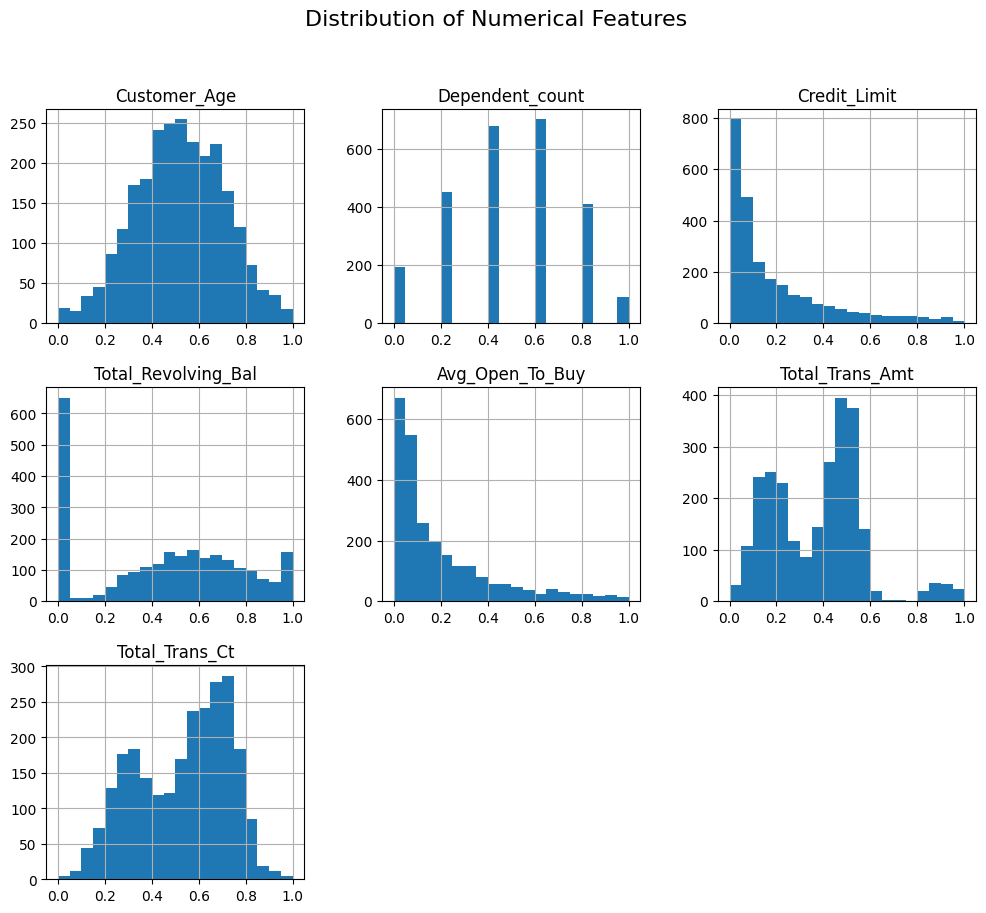

In [155]:
 # 1. Distribution of Key Features
plt.figure(figsize=(12, 6))
data[numerical_features].hist(bins=20, figsize=(12, 10), layout=(3, 3))
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

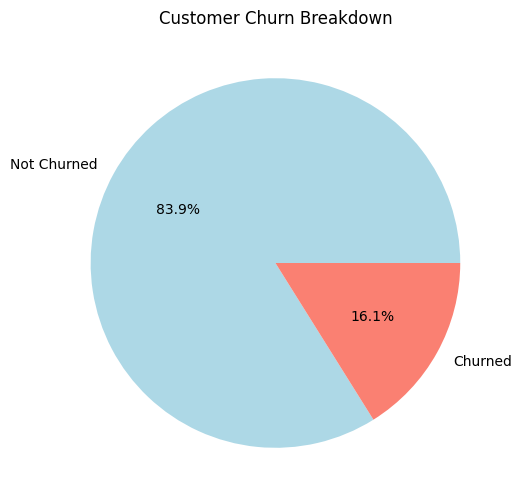

In [156]:
# 2. Churn vs. Non-Churn Breakdown
plt.figure(figsize=(6, 6))
labels = ['Not Churned', 'Churned']
plt.pie(data['Attrition_Flag'].value_counts(), labels=labels, autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title("Customer Churn Breakdown")
plt.show()

<Figure size 1000x600 with 0 Axes>

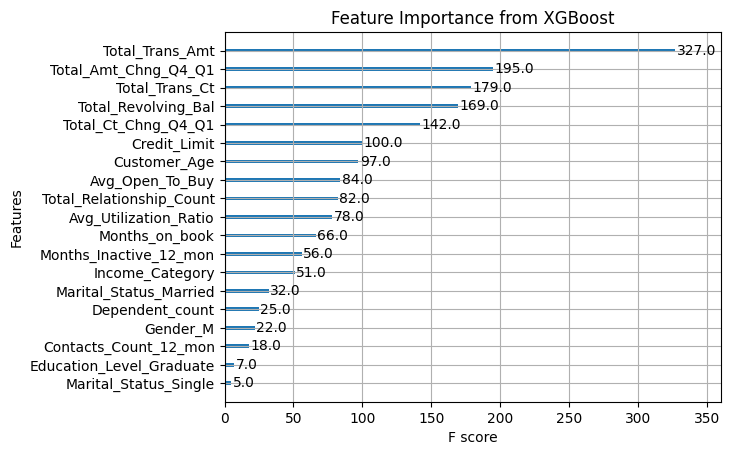

In [157]:
# 3. Feature Importance from XGBoost
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb_model, importance_type='weight')
plt.title("Feature Importance from XGBoost")
plt.show()

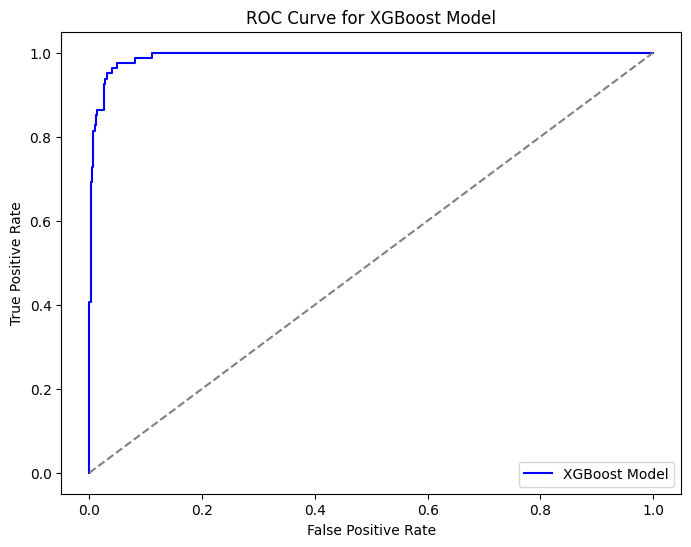

In [158]:
# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='XGBoost Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Model")
plt.legend()
plt.show()